This post uses the fastai library to classify images of the MNIST dataset (https://www.kaggle.com/competitions/digit-recognizer/data).

# Load Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [3]:
display(train_df.head(2))
display(test_df.head(2))

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def get_X_y(df: pd.DataFrame, 
            train: bool,
            frac: float = None,
            random_state: int = None):
    
    if train:
        sample_df = df.groupby("label").sample(frac=frac, random_state=random_state)
        X, y = sample_df.iloc[:, 1:].values, sample_df.iloc[:, 0].values
    else:
        X = df.values
        y = None
    
    X = X.reshape(-1, 28, 28).astype(np.uint8)
    return np.moveaxis(np.stack((X,) * 3, axis=1), source=1, destination=-1), y

In [8]:
train_X, train_y = get_X_y(train_df, train=True, frac=0.05, random_state=0)
test_X, _ = get_X_y(test_df, train=False)

In [10]:
import os

train_dir = "./data/train"
test_dir = "./data/test"

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    
for label in np.unique(train_y):
    if not os.path.exists(f"{train_dir}/{label}"):
        os.mkdir(f"{train_dir}/{label}")

In [11]:
from PIL import Image

In [12]:
for i in range(train_X.shape[0]): 
    Image.fromarray(train_X[i]).save(f"{train_dir}/{train_y[i]}/{i}.jpg")
    
for i in range(test_X.shape[0]):
    Image.fromarray(test_X[i]).save(f"{test_dir}/{i}.jpg")

# Train Model

In [13]:
from fastai.vision.all import *

In [14]:
dls = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y = parent_label,
                splitter = RandomSplitter(valid_pct = 0.5, seed = 0)
               ).dataloaders(train_dir)

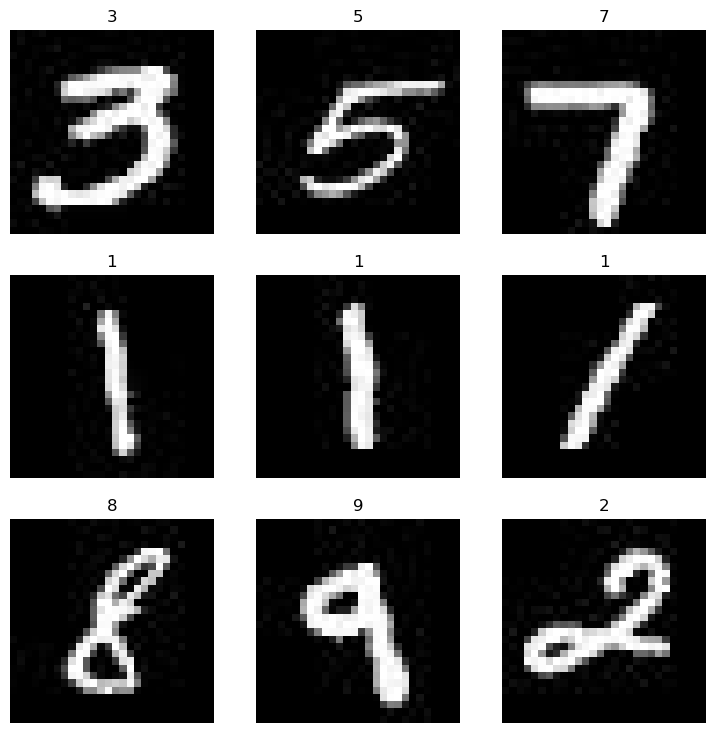

In [15]:
dls.show_batch()

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,3.052123,1.864471,0.635238,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.656031,1.243780,0.422857,00:06
1,1.263025,0.869192,0.276190,00:06
2,0.937062,0.807364,0.245714,00:06


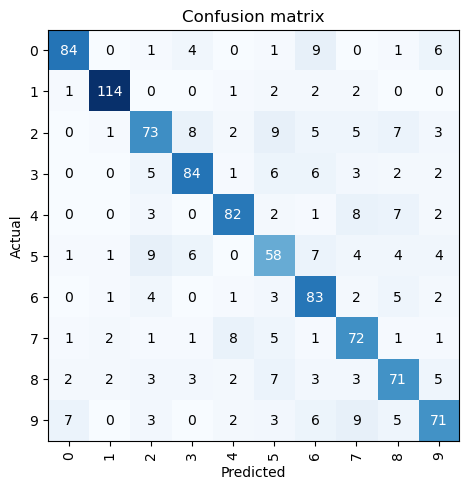

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

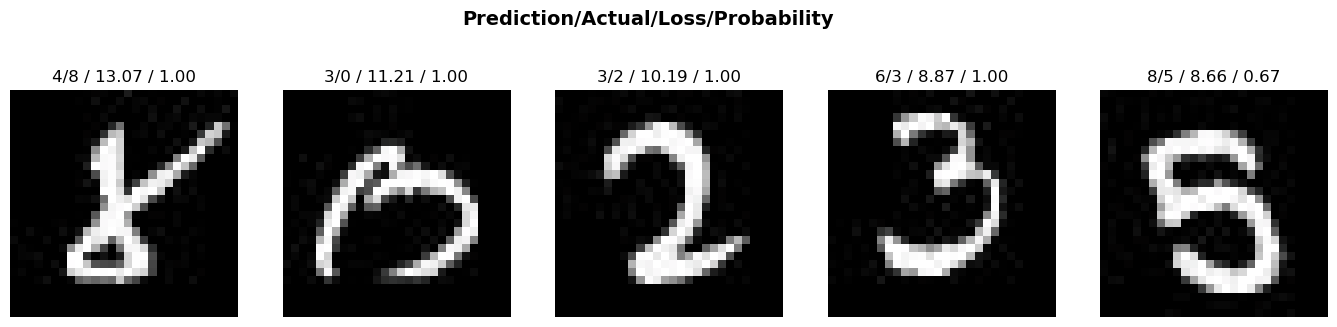

In [18]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

We can correct images annotations or remove them, using the `ImageClassifierCleaner`. That will show the images for each class (in the train or validation set) where the trained model had the highest classification error. Let's import the required modules:

In [19]:
from fastai.vision.widgets import *

In [20]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Each time we make a change in one class's and data set's (train/validation) samples, by reannotating/removing it, we need to run the following lines before changing to another class or data set, so the changes are applied to the actual data:

In [24]:
for ind in cleaner.delete(): cleaner.fns[ind].unlink()
for ind, cat in cleaner.change(): shutil.move(str(cleaner.fns[ind]), f"{train_dir}/{cat}")

In the end of validating the data, we need to create a new `DataLoaders` object, to reflect the changes made to the dataset, and retrain the model.

epoch,train_loss,valid_loss,error_rate,time
0,3.235463,1.952349,0.681602,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.616430,1.343637,0.436606,00:06
1,1.231681,0.954694,0.281220,00:06
2,0.940422,0.836008,0.250715,00:06


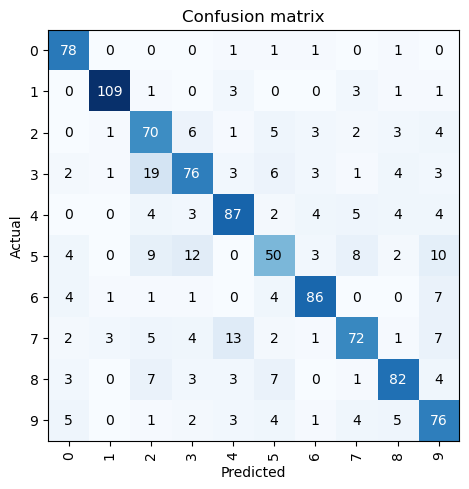

In [25]:
dls = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y = parent_label,
                splitter = RandomSplitter(valid_pct = 0.5, seed = 0)
               ).dataloaders(train_dir)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

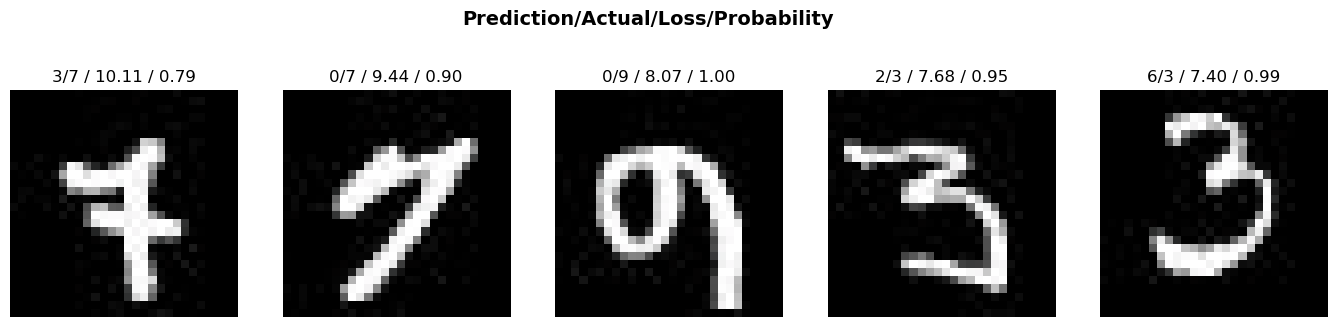

In [26]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

In this case, the model's performance decreased a little, so we would run the script again and revalidate the data.

# Test Model

In [27]:
pd.read_csv("./data/sample_submission.csv").head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [28]:
test_dl = dls.test_dl(get_image_files(test_dir))
preds_probs = learn.get_preds(dl=test_dl)[0]  # probs

In [29]:
preds = preds_probs.max(axis=1).indices
ids = np.arange(1, preds.shape[0]+1)
submit_df = pd.DataFrame(np.vstack((ids, preds)).T, columns=["ImageId", "Label"])

In [30]:
submit_df.to_csv("submission.csv", index=False)

We only used 5% of the data for training and validation, to make it faster, so, after iterating this process enough to be confident of our data processing and validation methods, and our model's architecture and hypeparameters, we would retrain and validate it on the whole dataset.